In [ ]:
from utama_core.entities.data.raw_vision import RawVisionData, RawRobotData
import pickle
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from temp.Filters import FIRPosOrientation, createStreams, KalmanCVOrientation

ModuleNotFoundError: No module named 'seaborn'

## Test for yellow robot id 1

In [2]:
measurements_stream = createStreams("noisy-raw.csv")[:700]
real_stream = createStreams("clean-raw.csv")[:700]
sum(sum((measurements_stream - real_stream)**2))

np.float64(614.6259038899511)

In [3]:
def error_square(real, predicted, num_cols = 2):
    return sum(sum((predicted - real)**2)[:num_cols])

In [55]:
kf = KalmanCVOrientation(
    dt=1/60,
    sigma_a=1.5,
    sigma_alpha=0.8,
    sigma_x=0.02, sigma_y=0.02, sigma_theta=0.05,
    mahalanobis_thresh=9.21  # Chi-square(3) 99% for [x,y,theta]
)
kalman_stream = []
for z in measurements_stream:
    state = kf.step(z)  # predict + update
    # If a frame is missing: state = kf.step(None)  # predict only

    # Use state: [x, y, vx, vy, theta, omega]
    x, y, vx, vy, theta, omega = state
    kalman_stream.append([x, y, theta])
error_square(real_stream, kalman_stream)

np.float64(37031.134715503606)

In [50]:
cutoffs = [x for x in range(1, 29)]
errors = [[]]
for i in range(0, len(cutoffs)):
    print(i)
    fir_stream = []
    fir = FIRPosOrientation(fs=60, window_len=5, cutoff=cutoffs[i])
    for z in measurements_stream:
        x, y, theta = fir.step(z)
        fir_stream.append([x, y, theta])
        state = kf.step(z)  # predict + update
    errors[0].append(error_square(fir_stream, real_stream))
errors.append([error_square(real_stream, measurements_stream)]*len(cutoffs))
errors.append([error_square(real_stream, kalman_stream)]*len(cutoffs))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


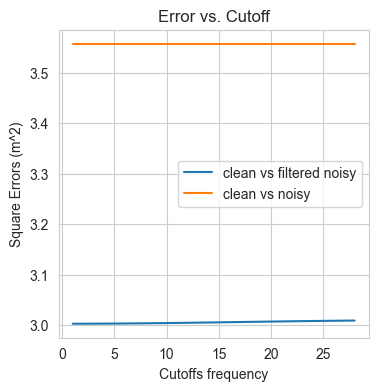

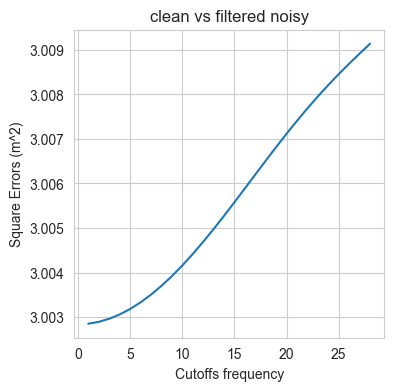

In [52]:
plt.figure(figsize = (4,4))
plt.plot(cutoffs, errors[0], label = "clean vs filtered noisy")
plt.plot(cutoffs, errors[1], label = "clean vs noisy")
plt.xlabel("Cutoffs frequency")
plt.ylabel("Square Errors (m^2)")
plt.title("Error vs. Cutoff")
plt.legend()
plt.show()
plt.figure(figsize = (4,4))
axes = sns.lineplot(x=cutoffs, y=errors[0])
axes.set_title("clean vs filtered noisy")
axes.set_xlabel("Cutoffs frequency")
axes.set_ylabel("Square Errors (m^2)")
plt.show()

In [36]:
window_lens = [x for x in range(1, 20)]
errors = [[]]
for i in range(0, len(window_lens)):
    print(i)
    fir_stream = []
    fir = FIRPosOrientation(fs=60, window_len=window_lens[i], cutoff=7)
    for z in measurements_stream:
        x, y, theta = fir.step(z)
        fir_stream.append([x, y, theta])
    errors[0].append(error_square(fir_stream, real_stream))
errors.append([error_square(real_stream, measurements_stream)]*len(window_lens))
errors[0]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


[np.float64(3.556951331101758),
 np.float64(3.317120231507521),
 np.float64(3.1481356741980226),
 np.float64(3.0422090992072164),
 np.float64(3.003502568497214),
 np.float64(3.0312525778855095),
 np.float64(3.1253603821616958),
 np.float64(3.285782734282231),
 np.float64(3.5124927095374634),
 np.float64(3.8054690516678273),
 np.float64(4.164721968510139),
 np.float64(4.590090285649792),
 np.float64(5.0815862113115156),
 np.float64(5.638993481996549),
 np.float64(6.262044836787515),
 np.float64(6.950367652010907),
 np.float64(7.7034213539488565),
 np.float64(8.521487099463982),
 np.float64(9.401407699974651)]

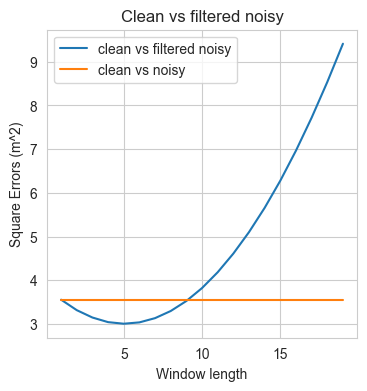

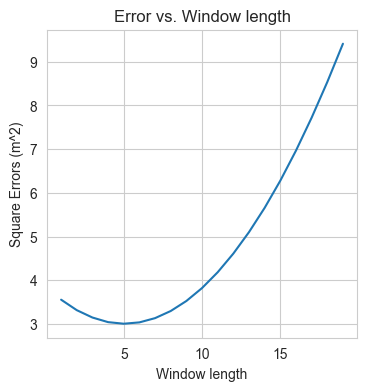

In [34]:
plt.figure(figsize = (4,4))
plt.plot(window_lens, errors[0], label = "clean vs filtered noisy")
plt.plot(window_lens, errors[1], label = "clean vs noisy")
plt.xlabel("Window length")
plt.ylabel("Square Errors (m^2)")
plt.title("Clean vs filtered noisy")
plt.legend()
plt.show()
plt.figure(figsize = (4,4))
axes = sns.lineplot(x=window_lens, y=errors[0])
axes.set_title("Error vs. Window length")
axes.set_xlabel("Window length")
axes.set_ylabel("Square Errors (m^2)")
plt.show()